# Does Sleep Amount Predict Stress Level?
### *Simple Linear Regression Model on data from Galaxy Watch4*

07/2023\


## Introduction:
Sleep amount is believed to be a predictor of stress levels due to the close interplay between sleep and stress. Sleep disturbances and sleep deprivation have been associated with increased stress responses and the release of stress hormones such as cortisol. Additionally, poor sleep quality impairs cognitive functioning and hinders individuals' ability to cope with daily stressors. Epidemiological studies have consistently shown a correlation between shorter sleep durations and higher levels of stress, anxiety, and depressive symptoms. This suggests that maintaining an adequate amount of sleep is crucial for stress regulation and overall well-being.

**Hypothesis**:
***Sleep amount is a predictor of stress level.***


To conduct the analysis, the data was collected from the *Samsung Health* app. Over the course of a year, I consistently wore a *Galaxy Watch 4* that tracked various parameters such as stress levels (using heart rate variations), sleep phases, sleep duration, and even snoring (I will provide a separate note on the analysis of this:)). The *Galaxy Watch 4* utilized features like Optical Heart Rate, Electrical Heart Signal, and Bioelectrical Impedance Analysis to capture these measurements. For further details regarding the data's specifics, I recommend referring to *Samsung's* developer forum for more information.

### To do:
1. Data Collection and Cleaning: Obtain data from the Samsung Health app, which includes measurements of stress levels, sleep phases, sleep duration, and related parameters captured by the Galaxy Watch.
2. Preliminary Visualization: Conduct initial visualizations of the variables under study, such as stress levels and sleep metrics. This step provides an overview and helps identify any patterns or trends in the data.
3. Correlation and Regression Analysis: Perform statistical analyses, such as correlation and regression analysis, to explore the relationships between stress levels and sleep variables. This analysis will help determine if there are significant associations or predictive factors between sleep amount and stress levels.
4. Summary: Summarize the findings from the analysis, highlighting key results and insights. Present any significant correlations or predictors discovered between sleep amount and stress levels. This step concludes the analysis and provides a clear understanding of the relationship between sleep and stress based on the collected data.


## 1. Data collection and Cleaning:
### Setting python environment

In [571]:
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import wes
import statsmodels.api as sm
import scipy.stats
import numpy as np
#visuals:
wes.set_palette('Royal2')
arfont = {'fontname':'Arial'}
tnrfont = {'fontname':'Times New Roman'}

cwd = os.getcwd() #setting cwd

### Loading stress data from Galaxy Watch

In [572]:
#creating df obj from multiple json files
stress_path = glob.glob(cwd + '/stress_data/*.json')
stress_list = []
for file in stress_path:
    file_list = pd.read_json(file)
    stress_list.append(file_list)
stress_df = pd.concat(stress_list) #creating df from list

stress_df['date'] = pd.to_datetime(stress_df['end_time']).dt.date #creating date column - stress; I'll use it later for merging df's
stress_df.drop(stress_df.iloc[:, 1:7], axis=1, inplace = True) #deleting unnecessary columns - stress

### Loading sleep data from Galaxy Watch

In [ ]:
sleep_raw = pd.read_excel('sleep_raw.xlsx') #reading sleep data
'''for col in sleep_raw:
    ind = sleep_raw.columns.get_loc(col)
    print(ind, col)''' #checking indexes in df
sleep_df = sleep_raw.iloc[:, [22,23,24,25,34]] #choosing right columns - sleep
sleep_df['date'] = pd.to_datetime(sleep_df['com.samsung.health.sleep.end_time']).dt.date #creating date column - sleep; I'll use it later for merging df's
sleep_df['sleep_duration'] = sleep_df['sleep_duration']/60 #changing minutes to hours

### Merging df's [Sleep & Stress] and deleting NAs

In [574]:
df = stress_df.merge(sleep_df, on='date', how='left') #merging df's on date
df = df.rename(columns = {'score':'stress_score', 'efficiency':'sleep_quality'}) #renaming cols
data = df.groupby('date')[['stress_score', 'sleep_cycle', 'sleep_score', 'sleep_quality', 'sleep_duration']].mean() # grouping vars by date with mean's
data.dropna(inplace=True) #dropping NA's from df

## 2. Preliminary Visualization
### Descriptive statistics

In [575]:
data.describe()

,stress_score,sleep_cycle,sleep_score,sleep_quality,sleep_duration
count,231.000000,231.000000,231.000000,231.000000,231.000000
mean,40.165591,3.719336,70.372294,81.711400,7.857299
std,18.521381,1.348103,9.210930,6.491702,2.136352
min,0.242038,0.500000,44.000000,55.000000,2.166667
25%,27.177380,3.000000,64.000000,79.000000,6.458333
50%,40.574607,4.000000,70.000000,83.000000,8.033333
75%,53.194581,5.000000,78.000000,86.000000,9.508333
max,87.208556,8.000000,91.000000,95.500000,11.816667


### Histograms of variables [Sleep hours, Stress level]

We have got some really cool histograms for both variables, and they look pretty nice with a Gaussian shape!


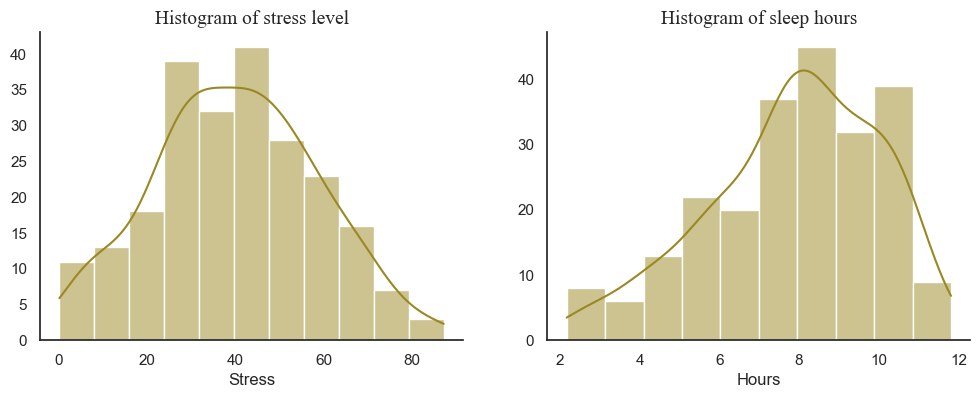

In [576]:
dimension_hist = (12, 4)
fig, axes = plt.subplots(1, 2, figsize = dimension_hist)
#stress histogram
stress_hist = sns.histplot(data, x="stress_score", fill=True, kde=True, ax=axes[0])
stress_hist.set_title("Histogram of stress level", **tnrfont, fontsize=14)
stress_hist.spines['right'].set_visible(False)
stress_hist.spines['top'].set_visible(False)
stress_hist.set_ylabel('')
stress_hist.set_xlabel('Stress', **arfont)
#sleep histogram
sleep_hist = sns.histplot(data, x="sleep_duration", fill=True, kde=True, ax=axes[1])
sleep_hist.set(title= "Histogram of sleep hour", )
sleep_hist.set_title('Histogram of sleep hours', **tnrfont, fontsize=14)
sleep_hist.spines['right'].set_visible(False)
sleep_hist.spines['top'].set_visible(False)
sleep_hist.set_ylabel('')
sleep_hist.set_xlabel('Hours', **arfont)
print('We have got some really cool histograms for both variables, and they look pretty nice with a Gaussian shape!')

### Line plots of variables with dates [Sleep hours, Stress level]

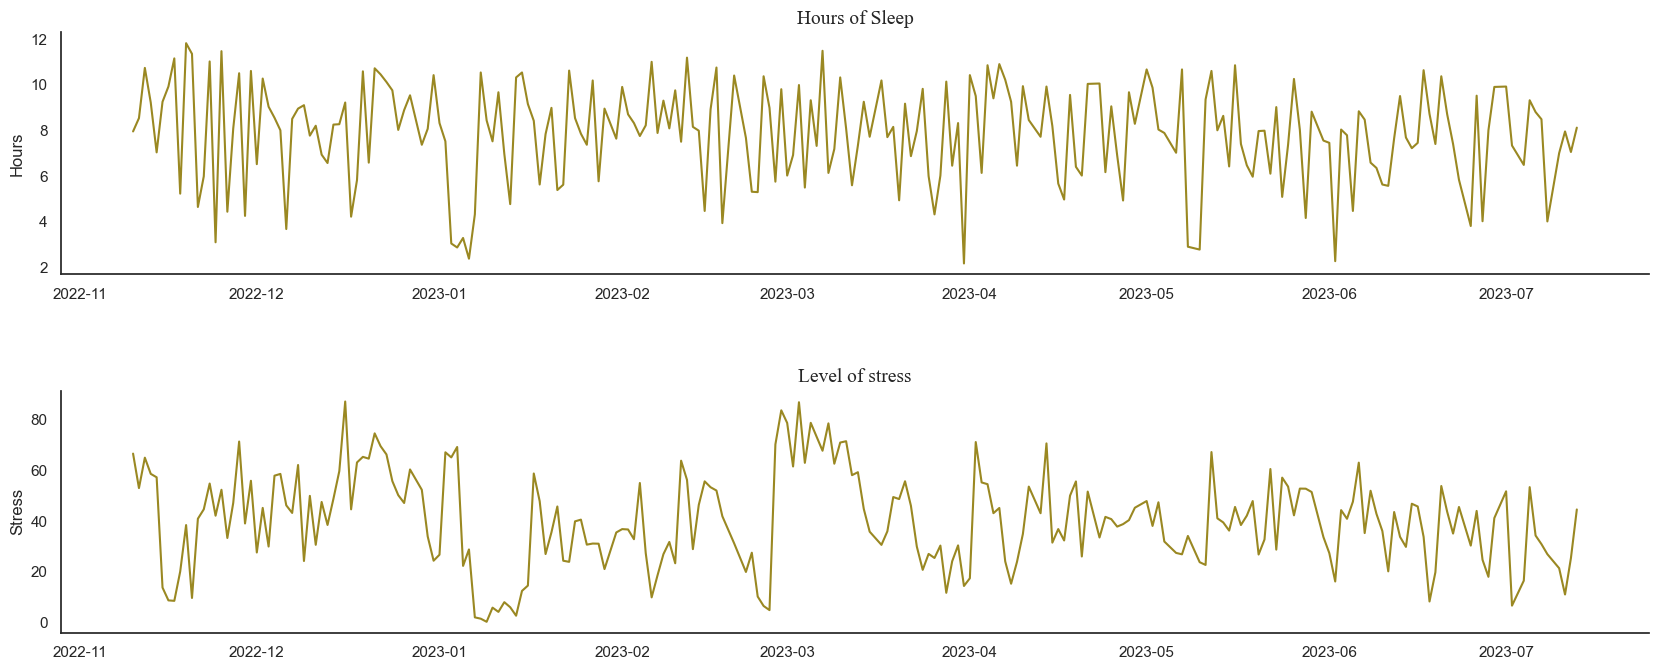

In [577]:
dimension_line = (18, 8)
fig, axes = plt.subplots(2,1, figsize=dimension_line)
fig.tight_layout(pad=5.0)

sleep_line = data['sleep_duration'].plot(ax=axes[0])
sleep_line.set_title('Hours of Sleep', **tnrfont, fontsize=14)
sleep_line.set_ylabel('Hours', **arfont)
sleep_line.set_xlabel('')
sleep_line.spines['right'].set_visible(False)
sleep_line.spines['top'].set_visible(False)

stress_line = data['stress_score'].plot(ax=axes[1])
stress_line.set_title('Level of stress', **tnrfont, fontsize=14)
stress_line.set_ylabel('Stress', **arfont)
stress_line.set_xlabel('')
stress_line.spines['right'].set_visible(False)
stress_line.spines['top'].set_visible(False)

## 3. Correlation and Regression Analysis
### Correlation matrix

In [578]:
data.corr()

,stress_score,sleep_cycle,sleep_score,sleep_quality,sleep_duration
stress_score,1.000000,0.119776,0.015143,0.006544,0.069656
sleep_cycle,0.119776,1.000000,0.196391,0.225599,0.747237
sleep_score,0.015143,0.196391,1.000000,0.285730,0.188187
sleep_quality,0.006544,0.225599,0.285730,1.000000,-0.004350
sleep_duration,0.069656,0.747237,0.188187,-0.004350,1.000000


In [579]:
correlation = scipy.stats.pearsonr(data['stress_score'], data['sleep_duration'])
print(f'Pearsons correlation coefficent between hours of sleep and stress level is {round(correlation.statistic,3)} and p-value is {round(correlation.pvalue,3)}.\nUnfortunately, we cant confidently guess what the regression line will look like...')

Pearsons correlation coefficent between hours of sleep and stress level is 0.07 and p-value is 0.292.
Unfortunately, we cant confidently guess what the regression line will look like...


### Linear Regression Model [sleep hours ~ stress level]

In [580]:
y = data['stress_score']
x = data['sleep_duration']
x = sm.add_constant(x)

model = sm.OLS(y,x).fit()
print(model.summary().tables[1])
print('The predictor beta is 0.604 with p > 0.05, indicating that sleep duration in this study is not a statistically significant predictor of stress levels.')

                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             35.4206      4.653      7.613      0.000      26.253      44.589
sleep_duration     0.6039      0.572      1.057      0.292      -0.522       1.730
The predictor beta is 0.604 with p > 0.05, indicating that sleep duration in this study is not a statistically significant predictor of stress levels.


### Regression Plot [sleep hours ~ stress level]

The scatter plot, along with the regression line drawn, bluntly summarizes our analysis.


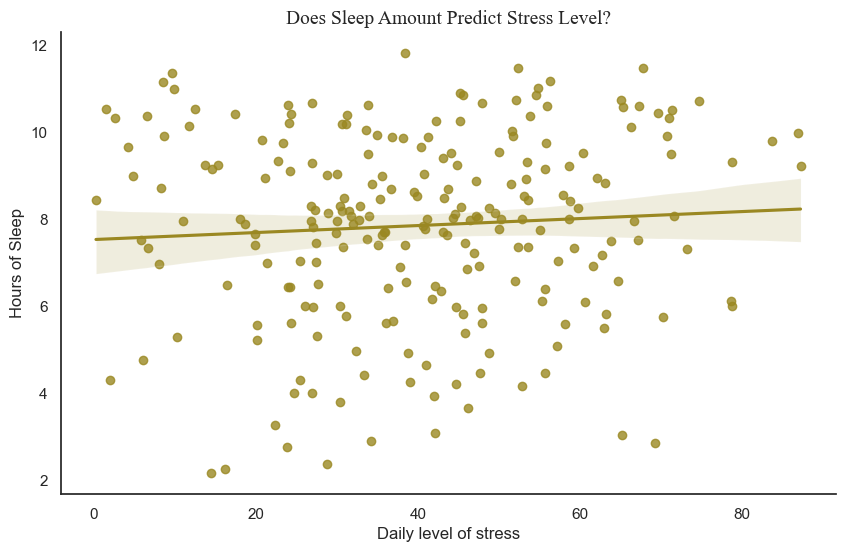

In [581]:
dimension_reg = (10,6)
fig, axes = plt.subplots(figsize=dimension_reg)
reg_plot = sns.regplot(x = data['stress_score'], y = data['sleep_duration'])
reg_plot.set_xlabel("Daily level of stress", **arfont)
reg_plot.set_ylabel("Hours of Sleep", **arfont)
reg_plot.set_title("Does Sleep Amount Predict Stress Level?", fontsize = 14, **tnrfont)
reg_plot.spines['right'].set_visible(False)
reg_plot.spines['top'].set_visible(False)
print('The scatter plot, along with the regression line drawn, bluntly summarizes our analysis.')

## 4. Summary:

The analysis of the data from the *Samsung Health* app suggests that *'how long you sleep doesn't really predict how stressed you feel'*. It seems like there are other factors that have a bigger impact on my stress levels.
However, if researchers delve into factors like lifestyle choices, work demands, and psychological factors, they can gain a better understanding of how sleep and stress are connected. These factors actually play a significant role in shaping both your sleep patterns and how stressed you feel. By studying how these factors interact, researchers can learn more about the complex relationship between sleep and stress. This knowledge can help them develop more effective ways to manage stress and improve overall well-being.